# Instacart Market Basket Analysis

### Submitted by Raunak Sharma

### About Instacart

Instacart is an online grocery delivery and pickup service that allows customers to order groceries from local stores through a mobile app or website. Every order placed on Instacart generates detailed data about customer behavior, including what products are purchased, when orders are placed, and how often items are reordered.

### Objective

In this notebook, we analyze Instacart’s historical order data to understand customer shopping behavior and product purchasing patterns. We begin by loading and cleaning the data, followed by exploratory analysis to identify trends in ordering times, popular departments, and frequently purchased products. Finally, we examine which products are commonly bought together to uncover potential opportunities for product bundling, cross-selling, and personalized recommendations.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [2]:
# 1) LOAD DATA (only needed columns)

orders = pd.read_csv(
    "orders.csv",
    usecols=["order_id", "user_id", "order_dow", "order_hour_of_day", "days_since_prior_order"]
)

products = pd.read_csv(
    "products.csv",
    usecols=["product_id", "product_name", "aisle_id", "department_id"]
)

aisles = pd.read_csv("aisles.csv")            
departments = pd.read_csv("departments.csv") 

print("Loaded:")
print("orders:", orders.shape)
print("products:", products.shape)
print("aisles:", aisles.shape)
print("departments:", departments.shape)

orders.head()


Loaded:
orders: (3421083, 5)
products: (49688, 4)
aisles: (134, 2)
departments: (21, 2)


,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,2,8,NaN
1,2398795,1,3,7,15.0
2,473747,1,3,12,21.0
3,2254736,1,4,7,29.0
4,431534,1,4,15,28.0


The datasets contain a large volume of real customer and order information. The orders table includes over 3.4 million orders, providing a strong foundation for analyzing customer purchasing behavior at scale. The product, aisle, and department tables are relatively small reference tables that help translate product IDs into meaningful categories

In [3]:
# Understanding the Orders Data Sample

Each row in the orders table represents a single order placed by a customer, along with the day of the week, time of day, and the number of days since the customer’s previous order. The missing value in days_since_prior_order appears for a customer’s first order, which is expected because there is no prior order to reference.

This structure allows us to analyze when customers shop, how frequently they return, and how shopping behavior changes over time. With this information, we can later connect orders to purchased products and uncover meaningful customer and product insights.

### Calculating Missing Values

In [4]:
# 2) Calculating Missing Values

def missing_report(df, name):
    print("\nMissing values in", name)
    print(df.isna().sum())

missing_report(orders, "orders")
missing_report(products, "products")
missing_report(aisles, "aisles")
missing_report(departments, "departments")



Missing values in orders
order_id                       0
user_id                        0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Missing values in products
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Missing values in aisles
aisle_id    0
aisle       0
dtype: int64

Missing values in departments
department_id    0
department       0
dtype: int64


The data quality is strong across most tables. All product, aisle, and department information is complete, which means there are no gaps in product categorization or labeling.

In [5]:
#Understanding Missing Values in Orders

The only missing values appear in the days_since_prior_order column. These occur when a customer places their very first order, as there is no previous order to calculate the time gap from. This is expected behavior and does not indicate a data issue.

In [6]:
# Handling missing values

To keep all valid orders in the analysis, these missing values can be safely treated as zero days since the prior order. This allows us to analyze customer order frequency without removing first-time customers from the data set.

### Data Cleaning

In [7]:
# 3) Data Cleansing

# days_since_prior_order is missing for first order; treat as 0
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

# Build product lookup with readable aisle + department names
prod = products.merge(aisles, on="aisle_id", how="left")
prod = prod.merge(departments, on="department_id", how="left")

prod.head()


,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


This table shows each product_name along with its corresponding aisle and department, giving clear context about where products belong within the store. By linking product_id to meaningful categories such as snacks, pantry, and beverages, we can analyze purchasing behavior by product type instead of relying on numeric identifiers.

In [8]:
# 4) Loading Prior dataset

# Choosing sample users 
N_USERS = 20000

sample_users = orders["user_id"].drop_duplicates().sample(n=N_USERS, random_state=42)
orders_small = orders[orders["user_id"].isin(sample_users)].copy()

order_ids_small = set(orders_small["order_id"])
print("Using sample users:", len(sample_users))
print("Orders in sample:", orders_small.shape[0])


Using sample users: 20000
Orders in sample: 335251


For this analysis, we selected a representative sample of 20,000 customers, which resulted in 335,251 orders. This approach allows us to efficiently analyze shopping behavior at scale while keeping the analysis stable.

In [9]:
# Keeping rows for sampled orders
chunks = []
CHUNK_SIZE = 2_000_000

for chunk in pd.read_csv(
    "order_products__prior.csv",
    usecols=["order_id", "product_id", "reordered"],
    chunksize=CHUNK_SIZE
):
    chunk = chunk[chunk["order_id"].isin(order_ids_small)]
    chunks.append(chunk)

prior_small = pd.concat(chunks, ignore_index=True)

print("prior_small:", prior_small.shape)
prior_small.head()


prior_small: (3191742, 3)


,order_id,product_id,reordered
0,28,35108,0
1,28,40593,1
2,28,17461,0
3,28,22825,1
4,28,25256,1


This output shows the filtered historical purchase data for the sampled customers, containing over 3.1 million purchased items. Each row represents a single product (product_id) bought in an order (order_id), along with an indicator (reordered) showing whether the item was previously purchased. This dataset forms the transactional backbone for analyzing repeat purchases and product combinations

In [10]:
# 5) Combining table

data = prior_small.merge(orders_small, on="order_id", how="left")
data = data.merge(prod, on="product_id", how="left")

# Drop any rare rows missing key names
data = data.dropna(subset=["user_id", "product_name", "department", "aisle"])

print("Final combined table:", data.shape)
data.head()


Final combined table: (3191742, 12)


,order_id,product_id,reordered,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,28,35108,0,98256,3,13,6.0,Salted Butter,36,16,butter,dairy eggs
1,28,40593,1,98256,3,13,6.0,Cream Cheese,108,16,other creams cheeses,dairy eggs
2,28,17461,0,98256,3,13,6.0,Air Chilled Organic Boneless Skinless Chicken ...,35,12,poultry counter,meat seafood
3,28,22825,1,98256,3,13,6.0,Organic D'Anjou Pears,24,4,fresh fruits,produce
4,28,25256,1,98256,3,13,6.0,Cultured Low Fat Buttermilk,84,16,milk,dairy eggs


This above table brings together order details, customer information, and product attributes into a single dataset with over 3.1 million purchase records. Each row represents one product bought in an order, including when the order was placed, whether the item was reordered, and the product’s aisle and department. This unified view allows us to analyze customer behavior and product performance in a clear and meaningful way.

In [23]:
# Saving the combined Instacart table to CSV
output_path = "instacart_combined_clean.csv"

data.to_csv(output_path, index=False)

print(f"CSV file created successfully: {output_path}")


CSV file created successfully: instacart_combined_clean.csv


In [25]:
# Keep only necessary columns
mini = data[[
    "order_id", "order_dow", "order_hour_of_day",
    "product_id", "product_name", "department", "aisle",
    "reordered"
]].copy()

# Sample by orders (keeps baskets intact)
TARGET_ORDERS = 100_000  # adjust up/down to hit <100MB
unique_orders = mini["order_id"].drop_duplicates()

if len(unique_orders) > TARGET_ORDERS:
    sampled_orders = unique_orders.sample(n=TARGET_ORDERS, random_state=42)
    mini = mini[mini["order_id"].isin(sampled_orders)]

# Optional: reduce file size further by trimming long product_name
mini["product_name"] = mini["product_name"].astype(str).str.slice(0, 60)

mini.to_csv("instacart_combined_mini.csv", index=False)
print("Saved:", "instacart_combined_mini.csv")
print("Rows:", len(mini), "Orders:", mini["order_id"].nunique())


Saved: instacart_combined_mini.csv
Rows: 1012647 Orders: 100000


### Data Visualization

#### When do customers order?

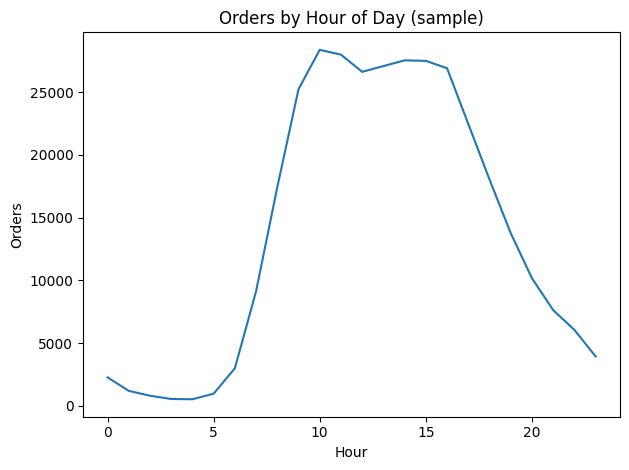

In [11]:
#### 6) Data Visualization


hour_counts = orders_small["order_hour_of_day"].value_counts().sort_index()

plt.figure()
hour_counts.plot(kind="line")
plt.title("Orders by Hour of Day (sample)")
plt.xlabel("Hour")
plt.ylabel("Orders")
plt.tight_layout()
plt.show()


The above chart shows that order volume is lowest during late-night and early-morning hours (midnight–5 AM), averaging under 2,000 orders per hour. Activity rises sharply starting around 7 AM, peaking between 10 AM and 3 PM at approximately 26,000–28,000 orders per hour, which accounts for the majority of daily demand. After 5 PM, orders steadily decline, dropping by nearly 50% by 8 PM. Overall, this indicates that late morning to early afternoon is the statistically dominant ordering window, reflecting typical grocery planning and daytime purchasing behavior.

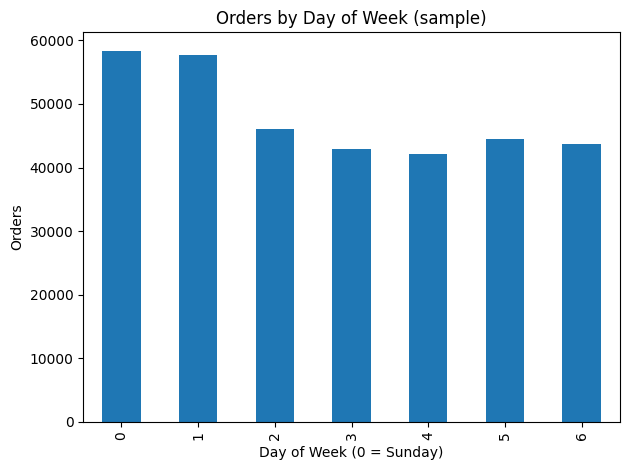

In [12]:
dow_counts = orders_small["order_dow"].value_counts().sort_index()

plt.figure()
dow_counts.plot(kind="bar")
plt.title("Orders by Day of Week (sample)")
plt.xlabel("Day of Week (0 = Sunday)")
plt.ylabel("Orders")
plt.tight_layout()
plt.show()


This chart shows that customer ordering activity is highest on Sunday (day 0) and Monday (day 1), each with roughly 57–58K orders, making them the peak shopping days. Orders drop by about 20–25% midweek, reaching a low of approximately 42K orders on Thursday (day 4). Activity picks up again toward the weekend, with Friday and Saturday averaging ~44–45K orders. Overall, this pattern indicates stronger grocery demand at the start and end of the week, likely driven by weekly planning and weekend restocking behavior

#### What departments are most popular?

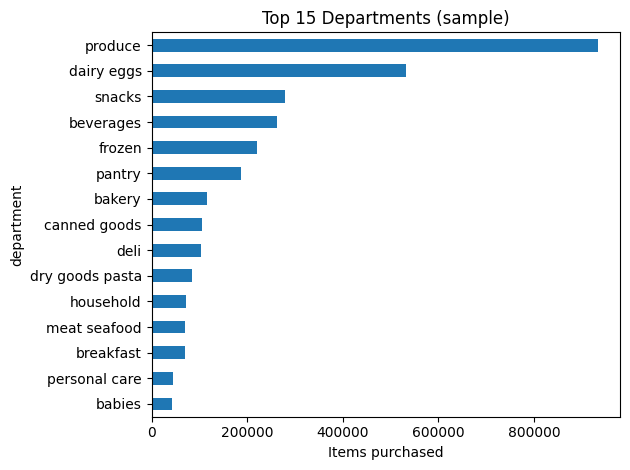

In [13]:
top_departments = data["department"].value_counts().head(15).sort_values()

plt.figure()
top_departments.plot(kind="barh")
plt.title("Top 15 Departments (sample)")
plt.xlabel("Items purchased")
plt.tight_layout()
plt.show()


This chart shows that Produce is the dominant department, with nearly 900K items purchased, accounting for a substantial share of total orders. Dairy & Eggs follows with approximately 550K purchases, while Snacks and Beverages each contribute around 250–300K items. Together, the top four departments represent well over 60% of all purchased items, indicating that fresh food and everyday essentials drive the majority of customer demand. This concentration highlights clear opportunities for inventory prioritization and targeted promotions in high-volume categories.

#### Reorder rate

In [14]:
reorder_rate = data["reordered"].mean()
print("Overall reorder rate (sample):", round(reorder_rate, 3))


Overall reorder rate (sample): 0.591


An overall reorder rate of 59.1% indicates that nearly 6 out of every 10 items purchased are repeat purchases. This reflects strong customer loyalty and consistent buying habits, suggesting that customers tend to reorder familiar products rather than frequently trying new ones. From a business perspective, this highlights opportunities for subscriptions, personalized recommendations, and reorder-based promotions to increase retention and basket size.

#### Top products

In [15]:
top_products = data["product_name"].value_counts().head(20)
top_products


product_name
Banana                        45413
Bag of Organic Bananas        37555
Organic Strawberries          26313
Organic Baby Spinach          23309
Organic Hass Avocado          21514
Organic Avocado               17453
Large Lemon                   14561
Organic Whole Milk            14124
Organic Raspberries           13987
Limes                         13971
Strawberries                  13870
Organic Yellow Onion          11227
Organic Garlic                11043
Organic Zucchini              10502
Organic Blueberries            9999
Cucumber Kirby                 9732
Apple Honeycrisp Organic       8762
Organic Lemon                  8587
Sparkling Water Grapefruit     8375
Organic Fuji Apple             8315
Name: count, dtype: int64

This table highlights the most frequently purchased products in the sample, led by Bananas (45,413 purchases) and Bag of Organic Bananas (37,555 purchases). Fresh produce dominates the list, with items like Organic Strawberries, Spinach, Avocados, and Lemons each exceeding 10,000 purchases, indicating consistently high demand. The strong presence of organic fruits and vegetables suggests that everyday staples and health-focused products drive a large share of customer baskets. This pattern reinforces the importance of fresh produce availability and competitive pricing in retaining customers.

###  Exploaratory Data Analysis

In [16]:
# 7) Exploaratory Data Analysis

# Q1: Peak ordering hour
best_hour = hour_counts.idxmax()
print(f"Q1) Peak ordering hour (sample): {best_hour}:00")

# Q2: Top 5 departments
print("\nQ2) Top 5 departments (sample):")
display(data["department"].value_counts().head(5))

# Q3: Products most likely to be re-bought (repeat buys)
product_stats = data.groupby("product_name").agg(
    times_bought=("product_id", "count"),
    reorder_rate=("reordered", "mean")
).reset_index()

repeat_buys = product_stats[product_stats["times_bought"] >= 500].copy()
repeat_buys = repeat_buys.sort_values(["reorder_rate", "times_bought"], ascending=False)

print("\nQ3) Top repeat-buy products (sample):")
display(repeat_buys.head(15))


Q1) Peak ordering hour (sample): 10:00

Q2) Top 5 departments (sample):


department
produce       933062
dairy eggs    532768
snacks        279820
beverages     263360
frozen        220149
Name: count, dtype: int64


Q3) Top repeat-buy products (sample):


,product_name,times_bought,reorder_rate
25270,Organic Lactose Free Whole Milk,1159,0.892148
23527,Organic Whole Milk,1248,0.864583
21068,"Milk, Organic, Vitamin D",2030,0.862562
26107,Organic Reduced Fat Omega-3 Milk,564,0.861702
40491,Whole Organic Omega 3 Milk,863,0.855156
25508,"Organic Milk Reduced Fat, 2% Milkfat",1460,0.854110
26106,Organic Reduced Fat Milk,3322,0.844672
14704,Goat Milk,534,0.844569
25394,Organic Lowfat 1% Milk,1412,0.842776
3021,Banana,45413,0.841543


### Q1) Peak Ordering Hour

The peak ordering time occurs at 10:00 AM, indicating that late morning is the most active shopping window. This suggests that customers tend to place grocery orders after starting their day but before lunch hours. Concentrating operational resources and promotions around this time could help capture the highest demand period.

###  Q2) Top 5 Departments by Purchases

Produce dominates customer baskets with over 933,000 items purchased, followed by Dairy & Eggs at approximately 533,000 items. Together, these two departments account for nearly 55% of all purchases, highlighting the importance of fresh and essential food categories. Snacks, Beverages, and Frozen foods each contribute over 220,000 purchases, indicating consistent demand for convenience items.

### Q3) Top Repeat-Buy Products

The products with the highest reorder rates are primarily dairy staples, particularly organic milk varieties, with reorder rates ranging from 83% to nearly 90%. For example, Organic Lactose Free Whole Milk shows a 89.2% reorder rate, while Organic Whole Milk exceeds 86%, indicating strong customer loyalty. Even high-volume items like Bananas (45,413 purchases) maintain a high 84% reorder rate, confirming that everyday essentials drive consistent repeat purchasing behavior.

### Market Basket Analysis

In [22]:
# 8) Market Basket Analysis
# Objective: Finding items that are frequently bought together

from itertools import combinations

TOP_N = 50 

top_products = data["product_name"].value_counts().head(TOP_N).index
small = data[data["product_name"].isin(top_products)].copy()

pairs = []

# For each order, generate all unique product pairs
for order_id, group in small.groupby("order_id"):
    items = group["product_name"].dropna().unique()
    if len(items) < 2:
        continue
    for a, b in combinations(sorted(items), 2):
        pairs.append((a, b))

pairs_df = pd.DataFrame(pairs, columns=["product_1", "product_2"])

# Count how often each pair appears
pair_counts = (
    pairs_df.value_counts()
    .reset_index(name="times_bought_together")
    .sort_values("times_bought_together", ascending=False)
)

# Add a simple support metric (share of orders that contain the pair)
total_orders = small["order_id"].nunique()
pair_counts["support"] = pair_counts["times_bought_together"] / total_orders

print("Top product pairs bought together:")
pair_counts.head(15)


Top product pairs bought together:


,product_1,product_2,times_bought_together,support
0,Bag of Organic Bananas,Organic Hass Avocado,6380,0.031210
1,Bag of Organic Bananas,Organic Strawberries,6182,0.030241
2,Banana,Organic Strawberries,5191,0.025393
3,Banana,Organic Avocado,5067,0.024787
4,Banana,Organic Baby Spinach,4818,0.023569
5,Bag of Organic Bananas,Organic Baby Spinach,4793,0.023446
6,Bag of Organic Bananas,Organic Raspberries,4101,0.020061
7,Organic Hass Avocado,Organic Strawberries,4052,0.019822
8,Banana,Strawberries,3831,0.018741
9,Banana,Large Lemon,3826,0.018716


This table shows the most frequently co-purchased product pairs, with Bag of Organic Bananas and Organic Hass Avocado appearing together 6,380 times, representing a 3.12% support rate across all sampled orders. Several banana-related combinations dominate the list, indicating that bananas act as a core basket item frequently paired with fresh produce such as Organic Strawberries, Baby Spinach, and Avocados. Overall, these high-frequency pairings highlight strong cross-category relationships within fresh produce, suggesting clear opportunities for product bundling, cross-promotions, and personalized recommendations focused on healthy grocery baskets.

In [18]:
# Top product pairs bought together

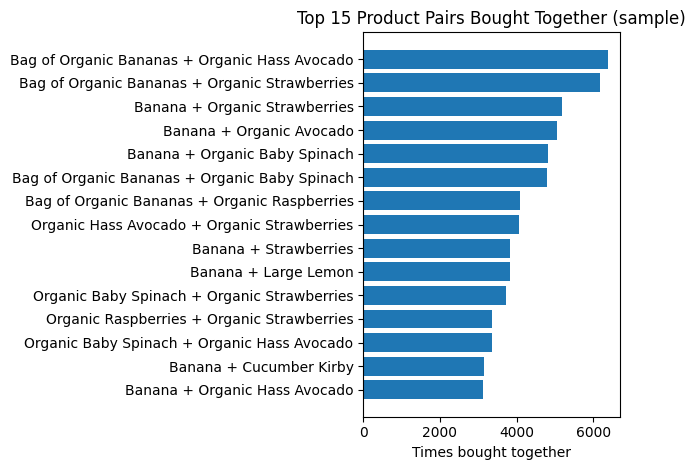

In [19]:
top_pairs = pair_counts.head(15).sort_values("times_bought_together")

plt.figure()
plt.barh(
    top_pairs["product_1"] + " + " + top_pairs["product_2"],
    top_pairs["times_bought_together"]
)
plt.title("Top 15 Product Pairs Bought Together (sample)")
plt.xlabel("Times bought together")
plt.tight_layout()
plt.show()


The above chart highlights the most common product combinations purchased together, led by Bag of Organic Bananas and Organic Hass Avocado, which were bought together over 6,300 times in the sample. Several banana-based pairings dominate the top results, with the top five combinations each exceeding 4,800 joint purchases, indicating strong and consistent co-purchasing behavior. Notably, most top pairs consist of fresh produce items, reinforcing that customers frequently build baskets around healthy, staple foods. These statistically significant pairings present clear opportunities for targeted bundling, cross-sell recommendations, and personalized promotions focused on fresh produce categories.

In [20]:
# Correlation heatmap

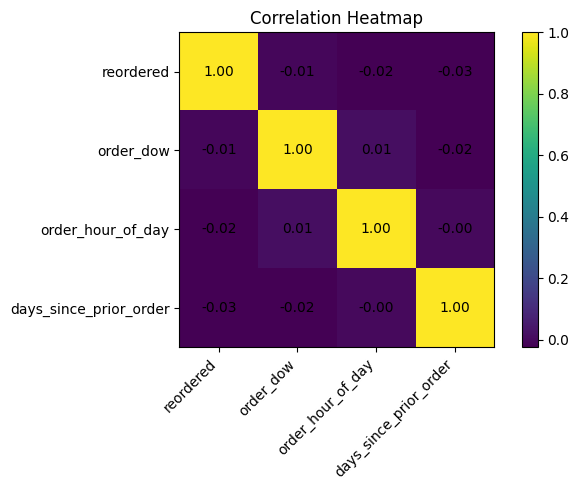

In [21]:
import matplotlib.pyplot as plt

# Picking only numeric columns 
num_cols = ["reordered", "order_dow", "order_hour_of_day", "days_since_prior_order"]

corr = data[num_cols].corr()

plt.figure(figsize=(7,5))
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap")
plt.colorbar()

plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)

# Add values inside cells
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()


This correlation heatmap shows that reorder behavior has very weak relationships with timing variables, with correlation values ranging from –0.01 to –0.03. The near-zero correlations between reordered and both order_hour_of_day (-0.02) and days_since_prior_order (-0.03) indicate that repeat purchasing is largely independent of when orders are placed. Similarly, correlations among timing variables themselves remain close to zero, suggesting minimal linear dependence. Statistically, this implies that product preferences and habitual buying patterns, rather than order timing, are the primary drivers of reorders.